In [5]:
import pandas as pd
import numpy as np
import re
import ast
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import skfuzzy as fuzz
from gensim.models import Word2Vec
from collections import defaultdict
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud

In [6]:
df_iniciativas = pd.read_excel("fuentes_informacion\\IniciativasPDET_preprocesadas.xlsx")
df_proyectos = pd.read_excel("fuentes_informacion\\ProyectosInversion_preprocesados.xlsx")

In [7]:
def normalizar_codigos(campo):
    if pd.isna(campo):
        return []
    elif isinstance(campo, list):
        return [str(x).zfill(5) for x in campo]
    elif isinstance(campo, str):
        try:
            lista = ast.literal_eval(campo)
            return [str(x).zfill(5) for x in lista] if isinstance(lista, list) else [str(lista).zfill(5)]
        except:
            return [campo.zfill(5)]
    elif isinstance(campo, (int, float)):
        return [str(int(campo)).zfill(5)]
    return []

df_iniciativas["codigos_dane_list"]     = df_iniciativas["codigosdane"].apply(normalizar_codigos)
df_proyectos["codigos_dane_list"]       = df_proyectos["codigoentidadnormalizado"].apply(normalizar_codigos)

# Combinar pilar + texto
df_iniciativas["texto_completo"]        = df_iniciativas["pilar"].fillna("") + " " + df_iniciativas["texto_preprocesado"]
df_iniciativas["tokens"]                = df_iniciativas["texto_completo"].fillna("").apply(lambda x: x.split())
df_proyectos["tokens"]                  = df_proyectos["texto_preprocesado"].fillna("").apply(lambda x: x.split())

# Filtrar textos cortos
df_iniciativas = df_iniciativas[df_iniciativas["tokens"].apply(len) >= 5].reset_index(drop=True)


In [8]:
corpus_total = df_iniciativas["tokens"].tolist() + df_proyectos["tokens"].tolist()

modelo_w2v = Word2Vec(
    sentences=corpus_total,
    vector_size=100,        
    window=3,               
    min_count=1,
    sg=1,
    seed=42,
    workers=1               
)


In [9]:
def vector_promedio(tokens, modelo, dim=100):
    vectores = [modelo.wv[token] for token in tokens if token in modelo.wv]
    return np.mean(vectores, axis=0) if vectores else np.zeros(dim)

# Calcular vector promedio UNA VEZ
df_iniciativas["vector"] = df_iniciativas["tokens"].apply(lambda x: vector_promedio(x, modelo_w2v))


In [10]:
# Normalizar
vectores = np.vstack(df_iniciativas["vector"].values)
vectores_norm = normalize(vectores, norm='l2')

# Entrenar PCA UNA VEZ (fijo)
pca = PCA(n_components=50, random_state=42)
vectores_reducidos = pca.fit_transform(vectores_norm)

# Guardar PCA para uso futuro
joblib.dump(pca, "fuentes_informacion/pca_model.pkl")


['fuentes_informacion/pca_model.pkl']

    N_clusters     FPC  Silhouette Score
0            2  0.5316            0.1547
1            3  0.4338            0.1694
2            4  0.3695            0.1859
3            5  0.3125            0.1639
4            6  0.2671            0.1412
5            7  0.1838            0.0933
6            8  0.1611            0.0875
7            9  0.1432            0.0659
8           10  0.1287           -0.0570
9           11  0.1167            0.0326
10          12  0.1356            0.0796


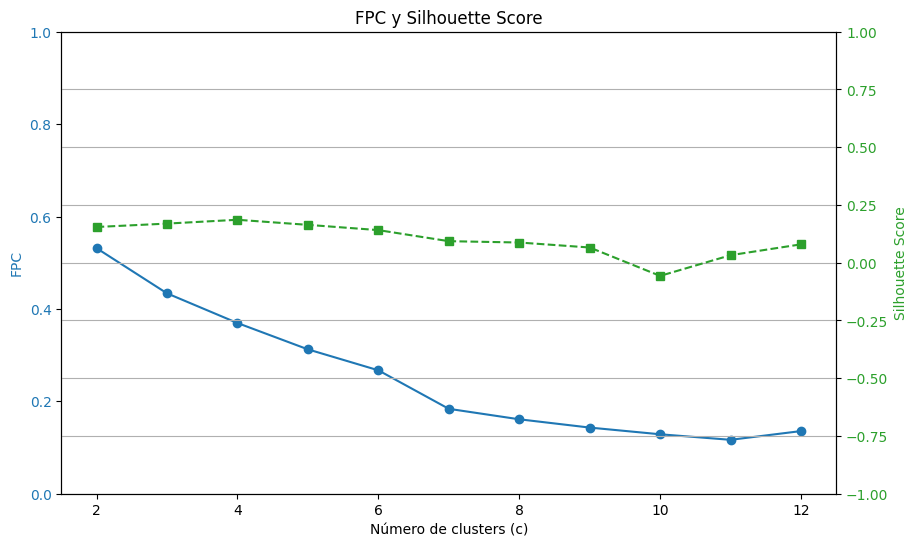

In [27]:
fpc_values = []
silhouette_values = []
cluster_range = list(range(2, 13))
X_T = vectores_reducidos.T

for c in cluster_range:
    cntr, u, _, _, _, _, fpc = fuzz.cluster.cmeans(
        X_T, c=c, m=1.5, error=0.005, maxiter=1000, seed=42
    )
    fpc_values.append(fpc)
    cluster_labels = np.argmax(u, axis=0)
    score = silhouette_score(vectores_reducidos, cluster_labels) if len(set(cluster_labels)) > 1 else np.nan
    silhouette_values.append(score)

# Tabla
tabla_metricas = pd.DataFrame({
    "N_clusters": cluster_range,
    "FPC": np.round(fpc_values, 4),
    "Silhouette Score": np.round(silhouette_values, 4)
})
print(tabla_metricas)

# Gráfico
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_xlabel('Número de clusters (c)')
ax1.set_ylabel('FPC', color='tab:blue')
ax1.plot(cluster_range, fpc_values, marker='o', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, 1)

ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color='tab:green')
ax2.plot(cluster_range, silhouette_values, marker='s', linestyle='--', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.set_ylim(-1, 1)

plt.title('FPC y Silhouette Score')
plt.grid(True)
plt.show()


In [28]:
def aplicar_fcm(df_original, vectores_reducidos, c=4):
    df = df_original.copy()

    X_T = vectores_reducidos.T
    cntr, u, _, _, _, _, fpc = fuzz.cluster.cmeans(
        X_T, c=c, m=1.5, error=0.005, maxiter=1000, seed=42
    )

    df[f"cluster_fcm_c{c}"] = np.argmax(u, axis=0)
    u_df = pd.DataFrame(u.T)

    # Tabla resumen
    resumen = []
    for i in range(c):
        indices = df[df[f"cluster_fcm_c{c}"] == i].index
        pertenencias = u_df.iloc[indices, i] if len(indices) > 0 else []
        resumen.append({
            "Cluster": i,
            "N_iniciativas": len(indices),
            "Pertenencia_promedio": round(pertenencias.mean(), 6) if len(indices) > 0 else 0,
            "Desv": round(pertenencias.std(), 6) if len(indices) > 0 else 0,
            "Min": round(pertenencias.min(), 6) if len(indices) > 0 else 0,
            "Max": round(pertenencias.max(), 6) if len(indices) > 0 else 0
        })

    tabla_resumen = pd.DataFrame(resumen)
    print(f"\n📋 Tabla resumen FCM con c={c}")
    print(tabla_resumen)

    # t-SNE
    tsne = TSNE(n_components=2, perplexity=30, n_iter=2000, random_state=42)
    tsne_result = tsne.fit_transform(vectores_reducidos)
    df["tsne_1"] = tsne_result[:, 0]
    df["tsne_2"] = tsne_result[:, 1]

    # Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x="tsne_1", y="tsne_2",
        hue=f"cluster_fcm_c{c}",
        data=df,
        palette="tab10",
        alpha=0.7
    )
    plt.title(f"FCM + PCA, c={c}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df, tabla_resumen, cntr, u



📋 Tabla resumen FCM con c=4
   Cluster  N_iniciativas  Pertenencia_promedio      Desv       Min       Max
0        0           5713              0.323422  0.032740  0.250635  0.439290
1        1           9791              0.359444  0.036502  0.256912  0.449223
2        2           6735              0.643477  0.141649  0.251479  0.891312
3        3          10768              0.530268  0.184371  0.251366  0.893979


c:\Users\CarlosAndresBalleste\miniconda3\envs\tfm-limpio\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


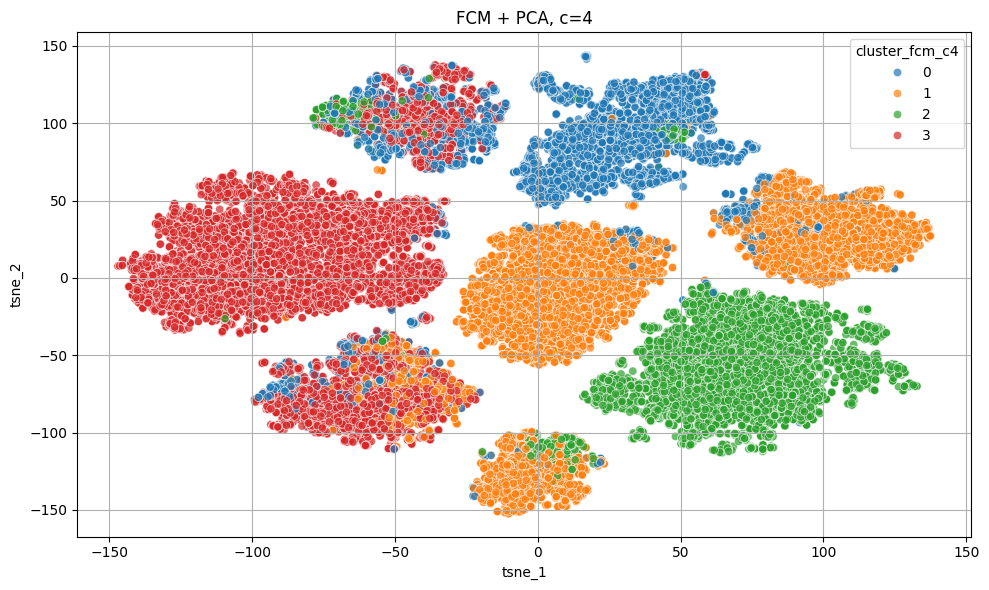


📋 Tabla resumen FCM con c=5
   Cluster  N_iniciativas  Pertenencia_promedio      Desv       Min       Max
0        0             57              0.232830  0.008491  0.218433  0.261376
1        1          10297              0.269366  0.020191  0.210402  0.314089
2        2           6388              0.624892  0.147238  0.204929  0.912151
3        3           8704              0.524983  0.177877  0.203215  0.891434
4        4           7561              0.244952  0.018817  0.202560  0.303974


c:\Users\CarlosAndresBalleste\miniconda3\envs\tfm-limpio\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


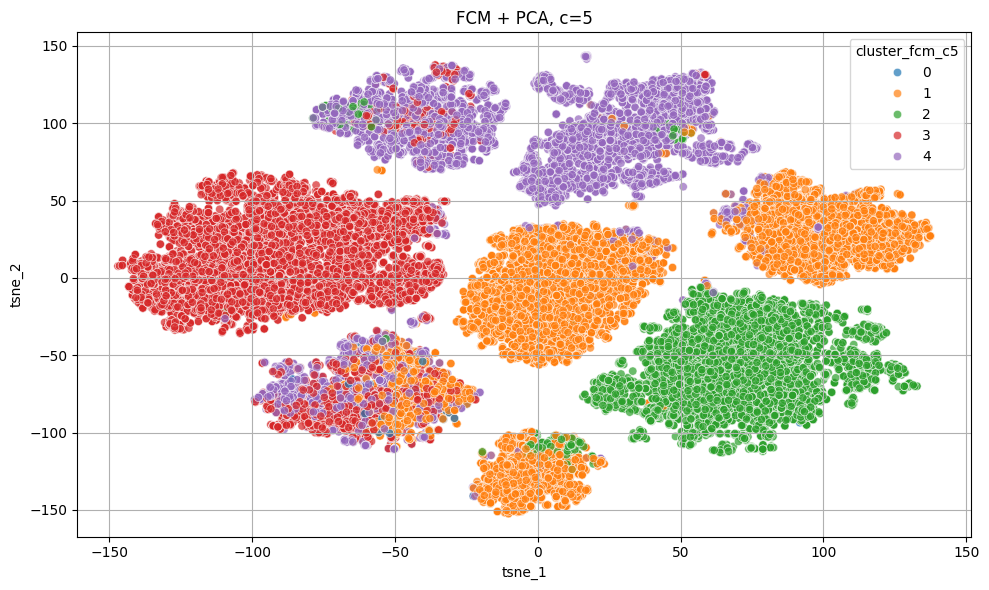

In [29]:
# c=4
df_c4, tabla_c4, cntr_c4, u_c4 = aplicar_fcm(df_iniciativas, vectores_reducidos, c=4)

# c=5
df_c5, tabla_c5, cntr_c5, u_c5 = aplicar_fcm(df_iniciativas, vectores_reducidos, c=5)


In [30]:
# Guardar modelo Word2Vec
modelo_w2v.save("fuentes_informacion/modelo_iniciativas_w2v.model")

# Guardar PCA (ya lo hicimos antes)
# joblib.dump(pca, "fuentes_informacion/pca_model.pkl")

# Guardar clustering c=4
joblib.dump({
    "df": df_c4[[
        "código_iniciativa", "codigodane", "vector", "cluster_fcm_c4",
        "tsne_1", "tsne_2", "subregión", "municipio/sujeto_concertación", "codigodane", "pilar", "título_iniciativa","descripción_iniciativa", "fase_de_formulación_de_la_iniciativa"
    ]],
    "centroides": cntr_c4,
    "u": u_c4,
    "pca": pca
}, "fuentes_informacion/_clustering_fcm_c4.pkl")


['fuentes_informacion/_clustering_fcm_c4.pkl']


📋 Tabla cruzada: Pilar vs Cluster FCM (c=4)
cluster_fcm_c4                                         0     1     2     3
pilar                                                                     
1. ORDENAMIENTO SOCIAL DE LA PROPIEDAD RURAL Y ...   265  3049     2     0
2. INFRAESTRUCTURA Y ADECUACIÓN DE TIERRAS          3786    16    67    18
3. SALUD RURAL                                       462   741    19  2333
4. EDUCACIÓN RURAL Y PRIMERA INFANCIA RURAL           17     4     4  7063
5. VIVIENDA RURAL, AGUA POTABLE Y SANEAMIENTO B...  1028     5   306  1354
6. REACTIVACIÓN ECONÓMICA Y PRODUCCIÓN AGROPECU...    20     0  6081     0
7. SISTEMA PARA LA GARANTÍA PROGRESIVA DEL DERE...    42  1486   254     0
8. RECONCILIACIÓN, CONVIVENCIA Y CONSTRUCCIÓN D...    93  4490     2     0


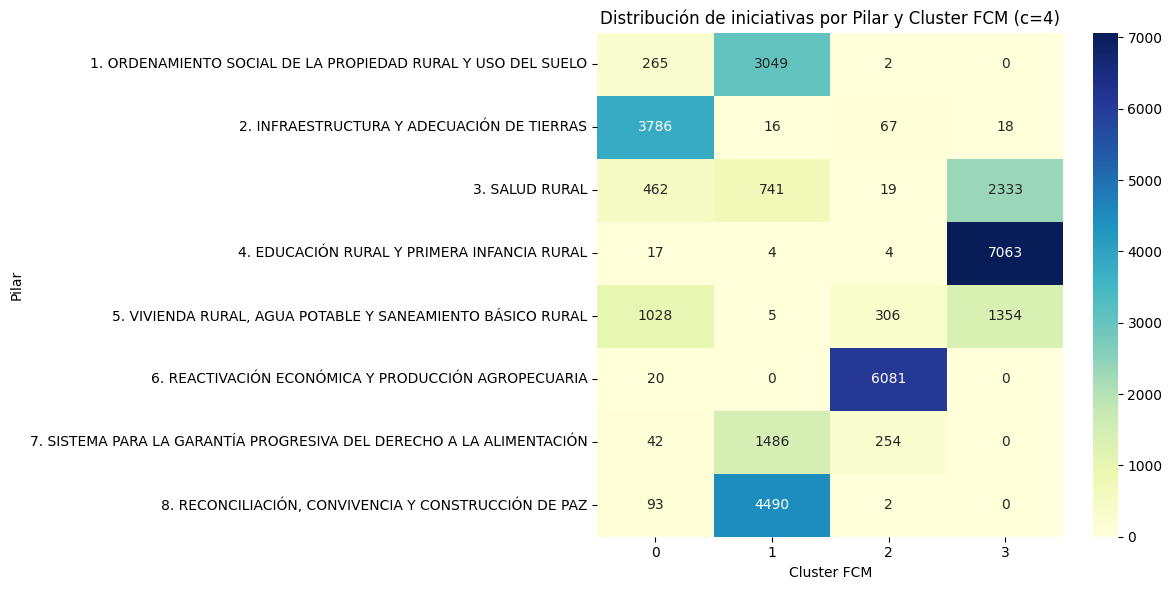

In [31]:
# Asegúrate de que df_c4 es el DataFrame con el resultado de c=4
# Y que contiene las columnas: 'pilar' y 'cluster_fcm_c4'

# Construir tabla cruzada
tabla_cruzada = pd.crosstab(df_c4["pilar"], df_c4["cluster_fcm_c4"])

# Mostrar tabla
print("\n📋 Tabla cruzada: Pilar vs Cluster FCM (c=4)")
print(tabla_cruzada)

# Visualizar heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(tabla_cruzada, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Distribución de iniciativas por Pilar y Cluster FCM (c=4)")
plt.xlabel("Cluster FCM")
plt.ylabel("Pilar")
plt.tight_layout()
plt.show()

In [39]:
# Vinculación semántica
umbral_similitud = 0.85

# ============================================
# 6. Vinculación semántica muchos a muchos
# ============================================

df_proyectos["vector"] = df_proyectos["tokens"].apply(lambda x: vector_promedio(x, modelo_w2v))


# Asociar clúster si ya existe df_c4 y la columna no está ya en df_iniciativas
if 'df_c4' in globals() and 'cluster_fcm_c4' not in df_iniciativas.columns:
    df_iniciativas = df_iniciativas.merge(
        df_c4[["código_iniciativa", "cluster_fcm_c4"]],
        on="código_iniciativa",
        how="left"
    )

# Crear índice por código DANE
dane_to_proyectos = defaultdict(list)
for _, p_row in df_proyectos.iterrows():
    for dane in p_row["codigos_dane_list"]:
        dane_to_proyectos[dane].append(p_row)


resultados = []

for _, i_row in tqdm(df_iniciativas.iterrows(), total=len(df_iniciativas), desc="Vinculando iniciativas con proyectos"):
    dane_i = set(i_row["codigos_dane_list"])
    vector_i = i_row["vector"]
    clus_i = i_row.get("cluster_fcm_c4", None)
    comparados = set()

    for dane in dane_i:
        for p_row in dane_to_proyectos.get(dane, []):
            p_key = p_row["bpin"]
            if p_key in comparados:
                continue
            comparados.add(p_key)

            vector_p = p_row["vector"]
            sim = cosine_similarity([vector_i], [vector_p])[0][0]
            if sim >= umbral_similitud:
                resultados.append({
                    "codigo_iniciativa": i_row["código_iniciativa"],
                    "cluster_iniciativa": clus_i,
                    #"texto_iniciativa": i_row["texto_preprocesado"],
                    "bpin": p_row["bpin"],
                    #"texto_proyecto": p_row["texto_preprocesado"],
                    #"codigos_dane_compartidos": list(set(p_row["codigos_dane_list"]) & dane_i),
                    "similitud_coseno": round(sim, 4)
                })

# Convertir a DataFrame
df_matches_muchos_a_muchos = pd.DataFrame(resultados)
print("🔎 Coincidencias encontradas:", len(df_matches_muchos_a_muchos))


Vinculando iniciativas con proyectos: 100%|██████████| 33007/33007 [6:24:41<00:00,  1.43it/s]   


🔎 Coincidencias encontradas: 8881322


In [40]:
df_matches_muchos_a_muchos.to_csv("fuentes_informacion\\vinculacion_semantica_resultados.csv", index=False, encoding='utf-8')

In [ ]:
#df_matches_muchos_a_muchos = pd.read_csv("fuentes_informacion\\vinculacion_semantica_resultados.csv", encoding="utf-8")


In [11]:
df_matches_ordenados = df_matches_muchos_a_muchos.sort_values(by="similitud_coseno", ascending=False)

# Unir textos completos

df_matches_ordenados = df_matches_ordenados.merge(
    df_iniciativas[["código_iniciativa", "texto_preprocesado", "pilar"]],
    left_on="codigo_iniciativa",
    right_on="código_iniciativa",
    how="left"
).merge(
    df_proyectos[["bpin", "texto_preprocesado"]],
    on="bpin",
    how="left",
    suffixes=("_iniciativa", "_proyecto")
)

# Reorganizar y renombrar columnas

df_matches_ordenados = df_matches_ordenados[[
    "codigo_iniciativa", "bpin", "cluster_iniciativa", "similitud_coseno", "pilar",
    "texto_preprocesado_iniciativa", "texto_preprocesado_proyecto"
]]

df_matches_ordenados.rename(columns={
    "codigo_iniciativa": "Código Iniciativa",
    "bpin": "BPIN Proyecto",
    "cluster_iniciativa": "Cluster Iniciativa",
    "similitud_coseno": "Similitud Coseno",
    "pilar": "Pilar",
    "texto_preprocesado_iniciativa": "Texto Iniciativa",
    "texto_preprocesado_proyecto": "Texto Proyecto"
}, inplace=True)

pd.set_option('display.max_colwidth', None)
display(df_matches_ordenados.head(3))

,Código Iniciativa,BPIN Proyecto,Cluster Iniciativa,Similitud Coseno,Pilar,Texto Iniciativa,Texto Proyecto
0,152418303208,2013000030122,2,0.9836,6. REACTIVACIÓN ECONÓMICA Y PRODUCCIÓN AGROPECUARIA,desarrollar cadena_productivo cafe_especial beneficiar_familia municipio andes_narino municipio andes_narino caracterizar productor cafe requerir fortalecimiento_cadena productivo siguiente_actividad implementacion sostenimiento_cultivo siembra ampliacion area ejecucion practica cultural plan_fertilizacion analisis_suelo control manejo_fitosanitario identificacion_potenciacion variedad adaptacion territorio beneficio_humedo fermentacion_secado dotacion familia productor necesidad maquinaria_equipo realizacion proceso garantizar mejoramiento_calidad grano_asimismo establecer condicion tecnico almacenamiento_empaque entrega producto pergamino_seco asociatividad desarrollar componente_socioempresarial fortalecer pequeno_productor componente organizativo tecnico administrativo_financiero mercadeo_comercializacion garantizar adecuado gestion actividad productivo fortalecimiento ampliacion base social generacion servicio asociado extension_agropecuario fondo_rotatorio igualmente fortalecer siguiente organizacion asolomo agrolanzo agroambiental tierra vivo asociacion union cafetera wilque asociacion agropecuario palacio andes transformacion construccion_dotacion puesto_marcha microplanta_procesamiento obtencion_cafe tostado_molido encapsulado derivado extension_rural capacitacion acceder programa extension_rural agropecuario acordar_ley generar capacidad_instalado cara implementar practica_agricola sello cultivo cafetero especial mercado_querer acceder infraestructura implementacion produccion_plantula campo requerir semilla material_insumos infraestructura_cafetero adecuado familia articulado programa_sustitucion cultivar cafe_especial requerir estudio_diseno dotacion_trilladora beneficiar productor municipio nivel_regional comercializacion inicialmente implementar_estrategia comercializacion cafe_especial calidad_producido requerir gestion_consecucion aliado_comercial tradicional aliado mercado especializado equipo_insumos necesario operacion logistica_transporte acompanamiento proceso comercializacion establecimiento caracteristica calidad_grano conducir seleccion mercado especializado posicionamiento_denominacion origen cafe_especial iniciativa incluir poblacion_victima municipio,NaN
1,119450291328,2022003190103,2,0.9820,6. REACTIVACIÓN ECONÓMICA Y PRODUCCIÓN AGROPECUARIA,fortalecer linea_productivo cacao establecimiento mantenimiento cultivo comercializacion cacao_tostado molido municipio_mercader cauca fortalecer linea_productivo cacao establecimiento mantenimiento cultivo comercializacion cacao_tostado molido municipio_mercader caucar siguiente accion promover cadena_productivo cacao familia productor suministro_insumos entrega_semilla mejorada conservacion_semilla nativo construccion vivero produccion material mejorado manejo_fitosanitario fermentacion beneficio equipo agricola fumigadora_guadana cava hoyo herramienta menor machete_palo pico capacitacion tecnificacion_agricola extension_rural eficiente proceso siembra produccion_comercializacion buscar sostenibilidad mercado miras desarrollo rural municipio planta tostadora cacao incluir plan funcionamiento procesamiento_transformacion cacao familia productor planta contar debido instalacion tecnologico maquinario utensilio adecuado proceso productivo tostadora molino bola prensadora moledora mezcladora masa empacadora asimismo deber dotar el estiba_secado almacenamiento dotacion vehiculo_transporte recoleccion cacao finca productor entregar planta_procesamiento paso requerir acompanamiento extension_agropecuario permanente proceso generacion_valor comercializacion mercado_local municipal regional asociatividad desarrollar componente_socioempresarial fortalecer pequeno_productor componente organizacion tecnico administrativo_financiero mercadeo_comercializacion garantizar adecuado g

In [12]:
df_matches_ordenados.count()

Código Iniciativa     8881322
BPIN Proyecto         8881322
Cluster Iniciativa    8881322
Similitud Coseno      8881322
Pilar                 8881322
Texto Iniciativa      8881322
Texto Proyecto          64249
dtype: int64

C:\Users\CarlosAndresBalleste\AppData\Local\Temp\ipykernel_28288\3742643194.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=distribucion_clusters.index, y=distribucion_clusters.values, palette="tab10")


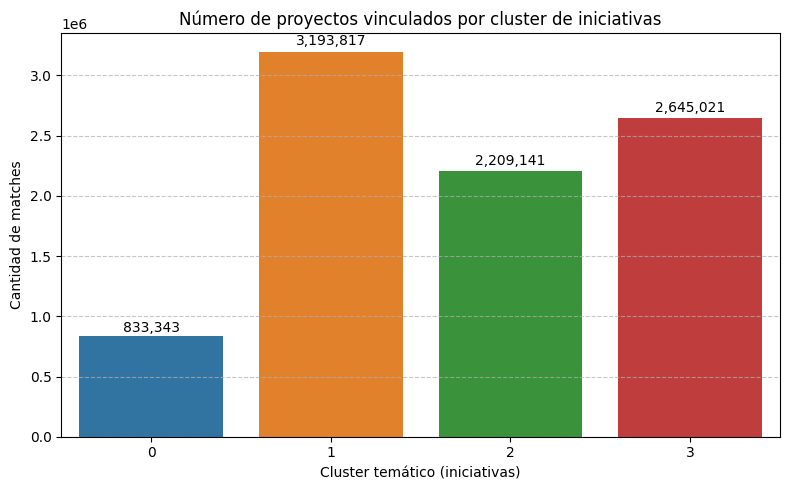

In [13]:
# Distribución de matches por cluster
distribucion_clusters = df_matches_ordenados["Cluster Iniciativa"].value_counts().sort_index()

# Graficar
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=distribucion_clusters.index, y=distribucion_clusters.values, palette="tab10")
plt.title("Número de proyectos vinculados por cluster de iniciativas")
plt.xlabel("Cluster temático (iniciativas)")
plt.ylabel("Cantidad de matches")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir los números en cada barra
for i, value in enumerate(distribucion_clusters.values):
    ax.text(i, value + (value * 0.01), f'{value:,.0f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
df_matches_ordenados.info()

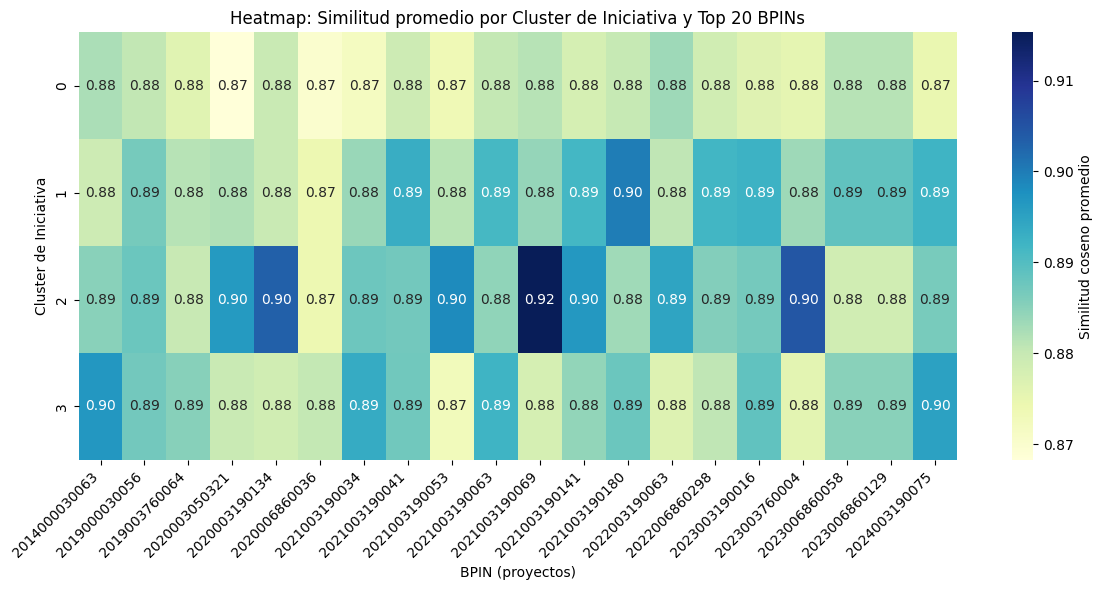

In [45]:
# Paso 1: Obtener los 20 BPIN con más relaciones
top_bpins = df_matches_ordenados["BPIN Proyecto"].value_counts().head(20).index
df_top_bpins = df_matches_ordenados[df_matches_ordenados["BPIN Proyecto"].isin(top_bpins)]

# Paso 2: Calcular la similitud promedio por cluster_iniciativa y BPIN
pivot_top = (
    df_top_bpins
    .groupby(["Cluster Iniciativa", "BPIN Proyecto"])["Similitud Coseno"]
    .mean()
    .reset_index()
    .pivot(index="Cluster Iniciativa", columns="BPIN Proyecto", values="Similitud Coseno")
    .fillna(0)
)

# Paso 3: Graficar el heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_top, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={"label": "Similitud coseno promedio"})
plt.title("Heatmap: Similitud promedio por Cluster de Iniciativa y Top 20 BPINs")
plt.xlabel("BPIN (proyectos)")
plt.ylabel("Cluster de Iniciativa")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


<Figure size 1400x600 with 0 Axes>

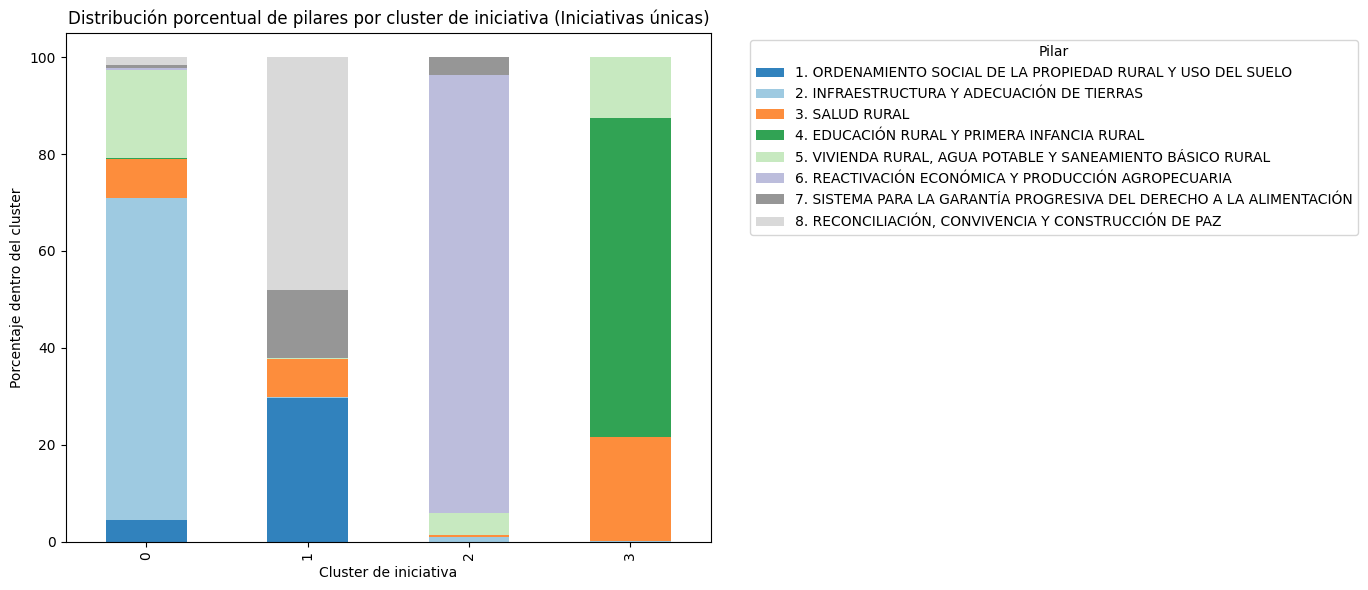

In [14]:
# Preparar dataframe de iniciativas únicas
iniciativas_unicas = df_matches_ordenados[["Código Iniciativa", "Cluster Iniciativa", "Pilar","Texto Iniciativa"]].drop_duplicates()

# Agrupar: cuántas iniciativas únicas por cluster y pilar
tabla_pilar_cluster = (
    iniciativas_unicas
    .groupby(["Cluster Iniciativa", "Pilar"])
    .size()
    .reset_index(name="cuenta")
    .pivot(index="Cluster Iniciativa", columns="Pilar", values="cuenta")
    .fillna(0)
)

# Normalizar por filas: porcentaje dentro de cada cluster
tabla_pilar_cluster_pct = tabla_pilar_cluster.div(tabla_pilar_cluster.sum(axis=1), axis=0) * 100

# Graficar distribución porcentual
plt.figure(figsize=(14, 6))
tabla_pilar_cluster_pct.plot(kind='bar', stacked=True, figsize=(14,6), colormap='tab20c')
plt.title("Distribución porcentual de pilares por cluster de iniciativa (Iniciativas únicas)")
plt.ylabel("Porcentaje dentro del cluster")
plt.xlabel("Cluster de iniciativa")
plt.legend(title="Pilar", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

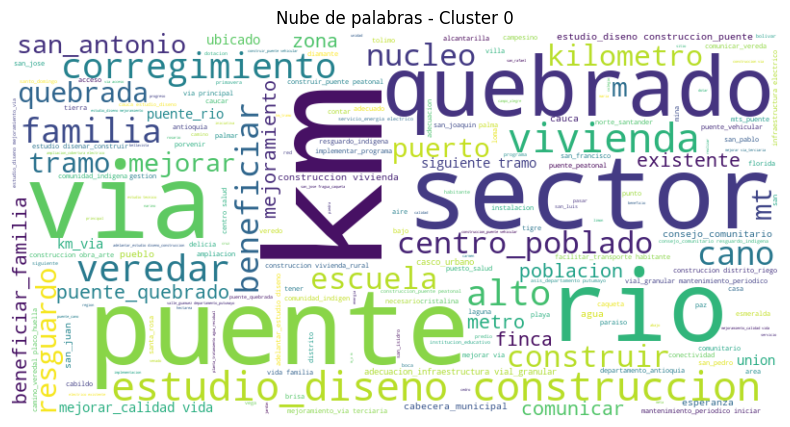

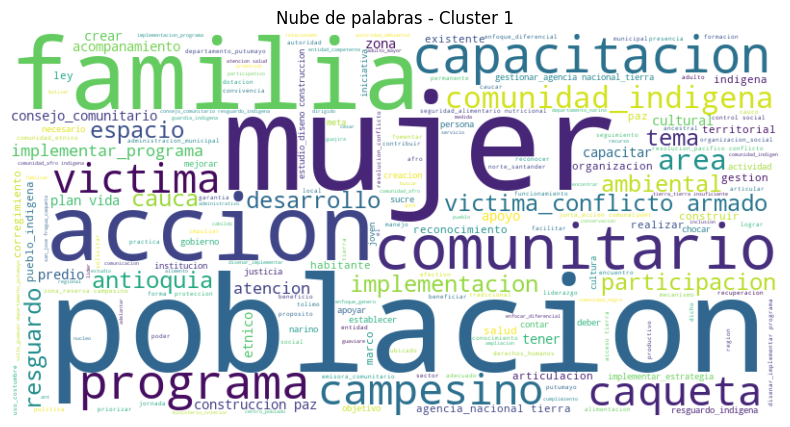

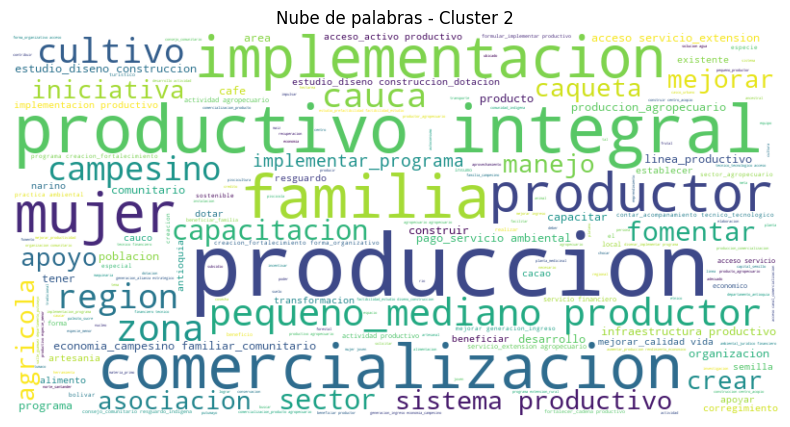

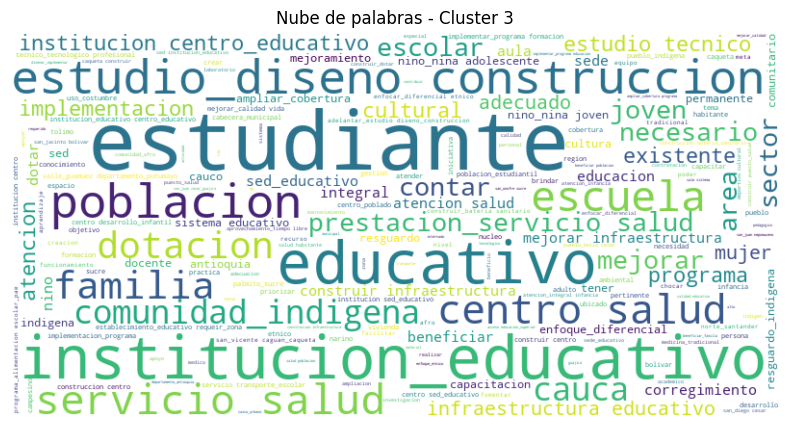

In [ ]:
# Lista de palabras a excluir
palabras_excluidas = {
    "rural", "zona_rural", "municipio", "vereda", "nucleo_veredal", "comunidad","territorio", "permitir", "garantizar", "implementar",
    "proyecto", "proceso", "gestionar", "desarrollar", "fortalecer", "fortalecimiento",
    "incluir", "requerir", "promover", "acciones", "estrategia", "generar"
}


# Filtrar palabras específicas y prefijos
def limpiar_texto(texto):
    return " ".join([
        palabra for palabra in texto.split()
        if palabra not in palabras_excluidas and not palabra.startswith("municipio_")
    ])

# Agrupar texto por cluster usando iniciativas_unicas
textos_por_cluster = (
    iniciativas_unicas[iniciativas_unicas["Texto Iniciativa"].notnull()]
    .groupby("Cluster Iniciativa")["Texto Iniciativa"]
    .apply(lambda x: " ".join(x))
)

# Generar nubes de palabras excluyendo ciertas palabras
for cluster_id, texto in textos_por_cluster.items():
    texto_filtrado = limpiar_texto(texto)
    if texto_filtrado.strip():
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_filtrado)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Nube de palabras - Cluster {cluster_id}")
        plt.show()
    else:
        print(f"Cluster {cluster_id} quedó sin texto después del filtrado.")

In [27]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# -----------------------------
# 1. Agrupar texto por clúster
# -----------------------------
# Asegúrate de tener un DataFrame llamado 'iniciativas_unicas'
# con columnas 'Cluster Iniciativa' y 'Texto Iniciativa'

df_cluster_textos = (
    iniciativas_unicas
    .groupby('Cluster Iniciativa')['Texto Iniciativa']
    .apply(lambda textos: ' '.join(textos))
    .reset_index()
)

# -----------------------------
# 2. Aplicar TF-IDF
# -----------------------------
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(df_cluster_textos['Texto Iniciativa'])

# -----------------------------
# 3. Extraer top n palabras por clúster
# -----------------------------
def top_palabras_por_cluster(tfidf_matrix, vectorizer, top_n=15):
    feature_names = np.array(vectorizer.get_feature_names_out())
    resultados = []

    for i, fila in enumerate(tfidf_matrix.toarray()):
        top_indices = fila.argsort()[::-1][:top_n]
        palabras = feature_names[top_indices]
        pesos = fila[top_indices]
        for palabra, peso in zip(palabras, pesos):
            resultados.append({
                "cluster": f"Cluster {i}",
                "palabra": palabra,
                "peso_tfidf": round(peso, 4)
            })

    return pd.DataFrame(resultados)

df_resultados = top_palabras_por_cluster(tfidf_matrix, vectorizer, top_n=15)

# -----------------------------
# 4. Ordenar y mostrar todo en consola
# -----------------------------
df_resultados.sort_values(by=["cluster", "peso_tfidf"], ascending=[True, False], inplace=True)

# Configurar pandas para mostrar todo sin truncar
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Imprimir resultados completos
print(df_resultados)



      cluster                    palabra  peso_tfidf
0   Cluster 0                     vereda      0.3623
1   Cluster 0                  comunidad      0.3018
2   Cluster 0                         km      0.2882
3   Cluster 0                  municipio      0.2726
4   Cluster 0               construccion      0.2303
5   Cluster 0                        via      0.1879
6   Cluster 0                      rural      0.1870
7   Cluster 0             estudio_diseno      0.1863
8   Cluster 0                 zona_rural      0.1519
9   Cluster 0                    mejorar      0.1405
10  Cluster 0                     puente      0.1324
11  Cluster 0        construccion_puente      0.1280
12  Cluster 0                    familia      0.1269
13  Cluster 0                  construir      0.1248
14  Cluster 0                   vivienda      0.1204
15  Cluster 1                  municipio      0.4148
16  Cluster 1                  comunidad      0.3221
17  Cluster 1                      rural      

In [50]:
joblib.dump(df_iniciativas[["código_iniciativa", "subregión", "codigodane", "municipio/sujeto_concertación", "pilar", "título_iniciativa","descripción_iniciativa", "vector"]], "fuentes_informacion\\vectores_iniciativas.pkl")

['fuentes_informacion\\vectores_iniciativas.pkl']

In [51]:
modelo_w2v.save("fuentes_informacion\\modelo_iniciativas_w2v.model")

In [ ]:
# 1. Cargar archivos
df_vectores = joblib.load("fuentes_informacion/vectores_iniciativas.pkl")
clustering_data = joblib.load("fuentes_informacion/_clustering_fcm_c4.pkl")

# 2. Extraer solo código y cluster
df_clusters = clustering_data["df"][["código_iniciativa", "cluster_fcm_c4"]]

# 3. Merge y selección explícita de columnas deseadas
df_merged = df_vectores.merge(df_clusters, on="código_iniciativa", how="left")

# 4. Reordenar y limitar columnas
columnas_deseadas = [
    "código_iniciativa", "subregión", "codigodane", "municipio/sujeto_concertación",
    "pilar", "título_iniciativa", "descripción_iniciativa", "vector", "cluster_fcm_c4"
]
df_final = df_merged[columnas_deseadas]

# 5. Guardar archivo actualizado
joblib.dump(df_final, "fuentes_informacion/vectores_iniciativas.pkl")



✅ Archivo actualizado con las columnas deseadas, sin duplicados.
